Data loaded: 912192 bars

Backtest running with BB(30, 2.6), ATR(14)...
Backtest completed: 20553 trades generated

BACKTEST EVALUATION
Total PnL:             99,823 USD  (20553 trades)
Risk per Trade:        10,000 USD
Avg PnL:                 4.86 USD
Avg Drawdown:           23.36 USD
Avg Duration:              21 minutes
Win Rate:                72.1 %



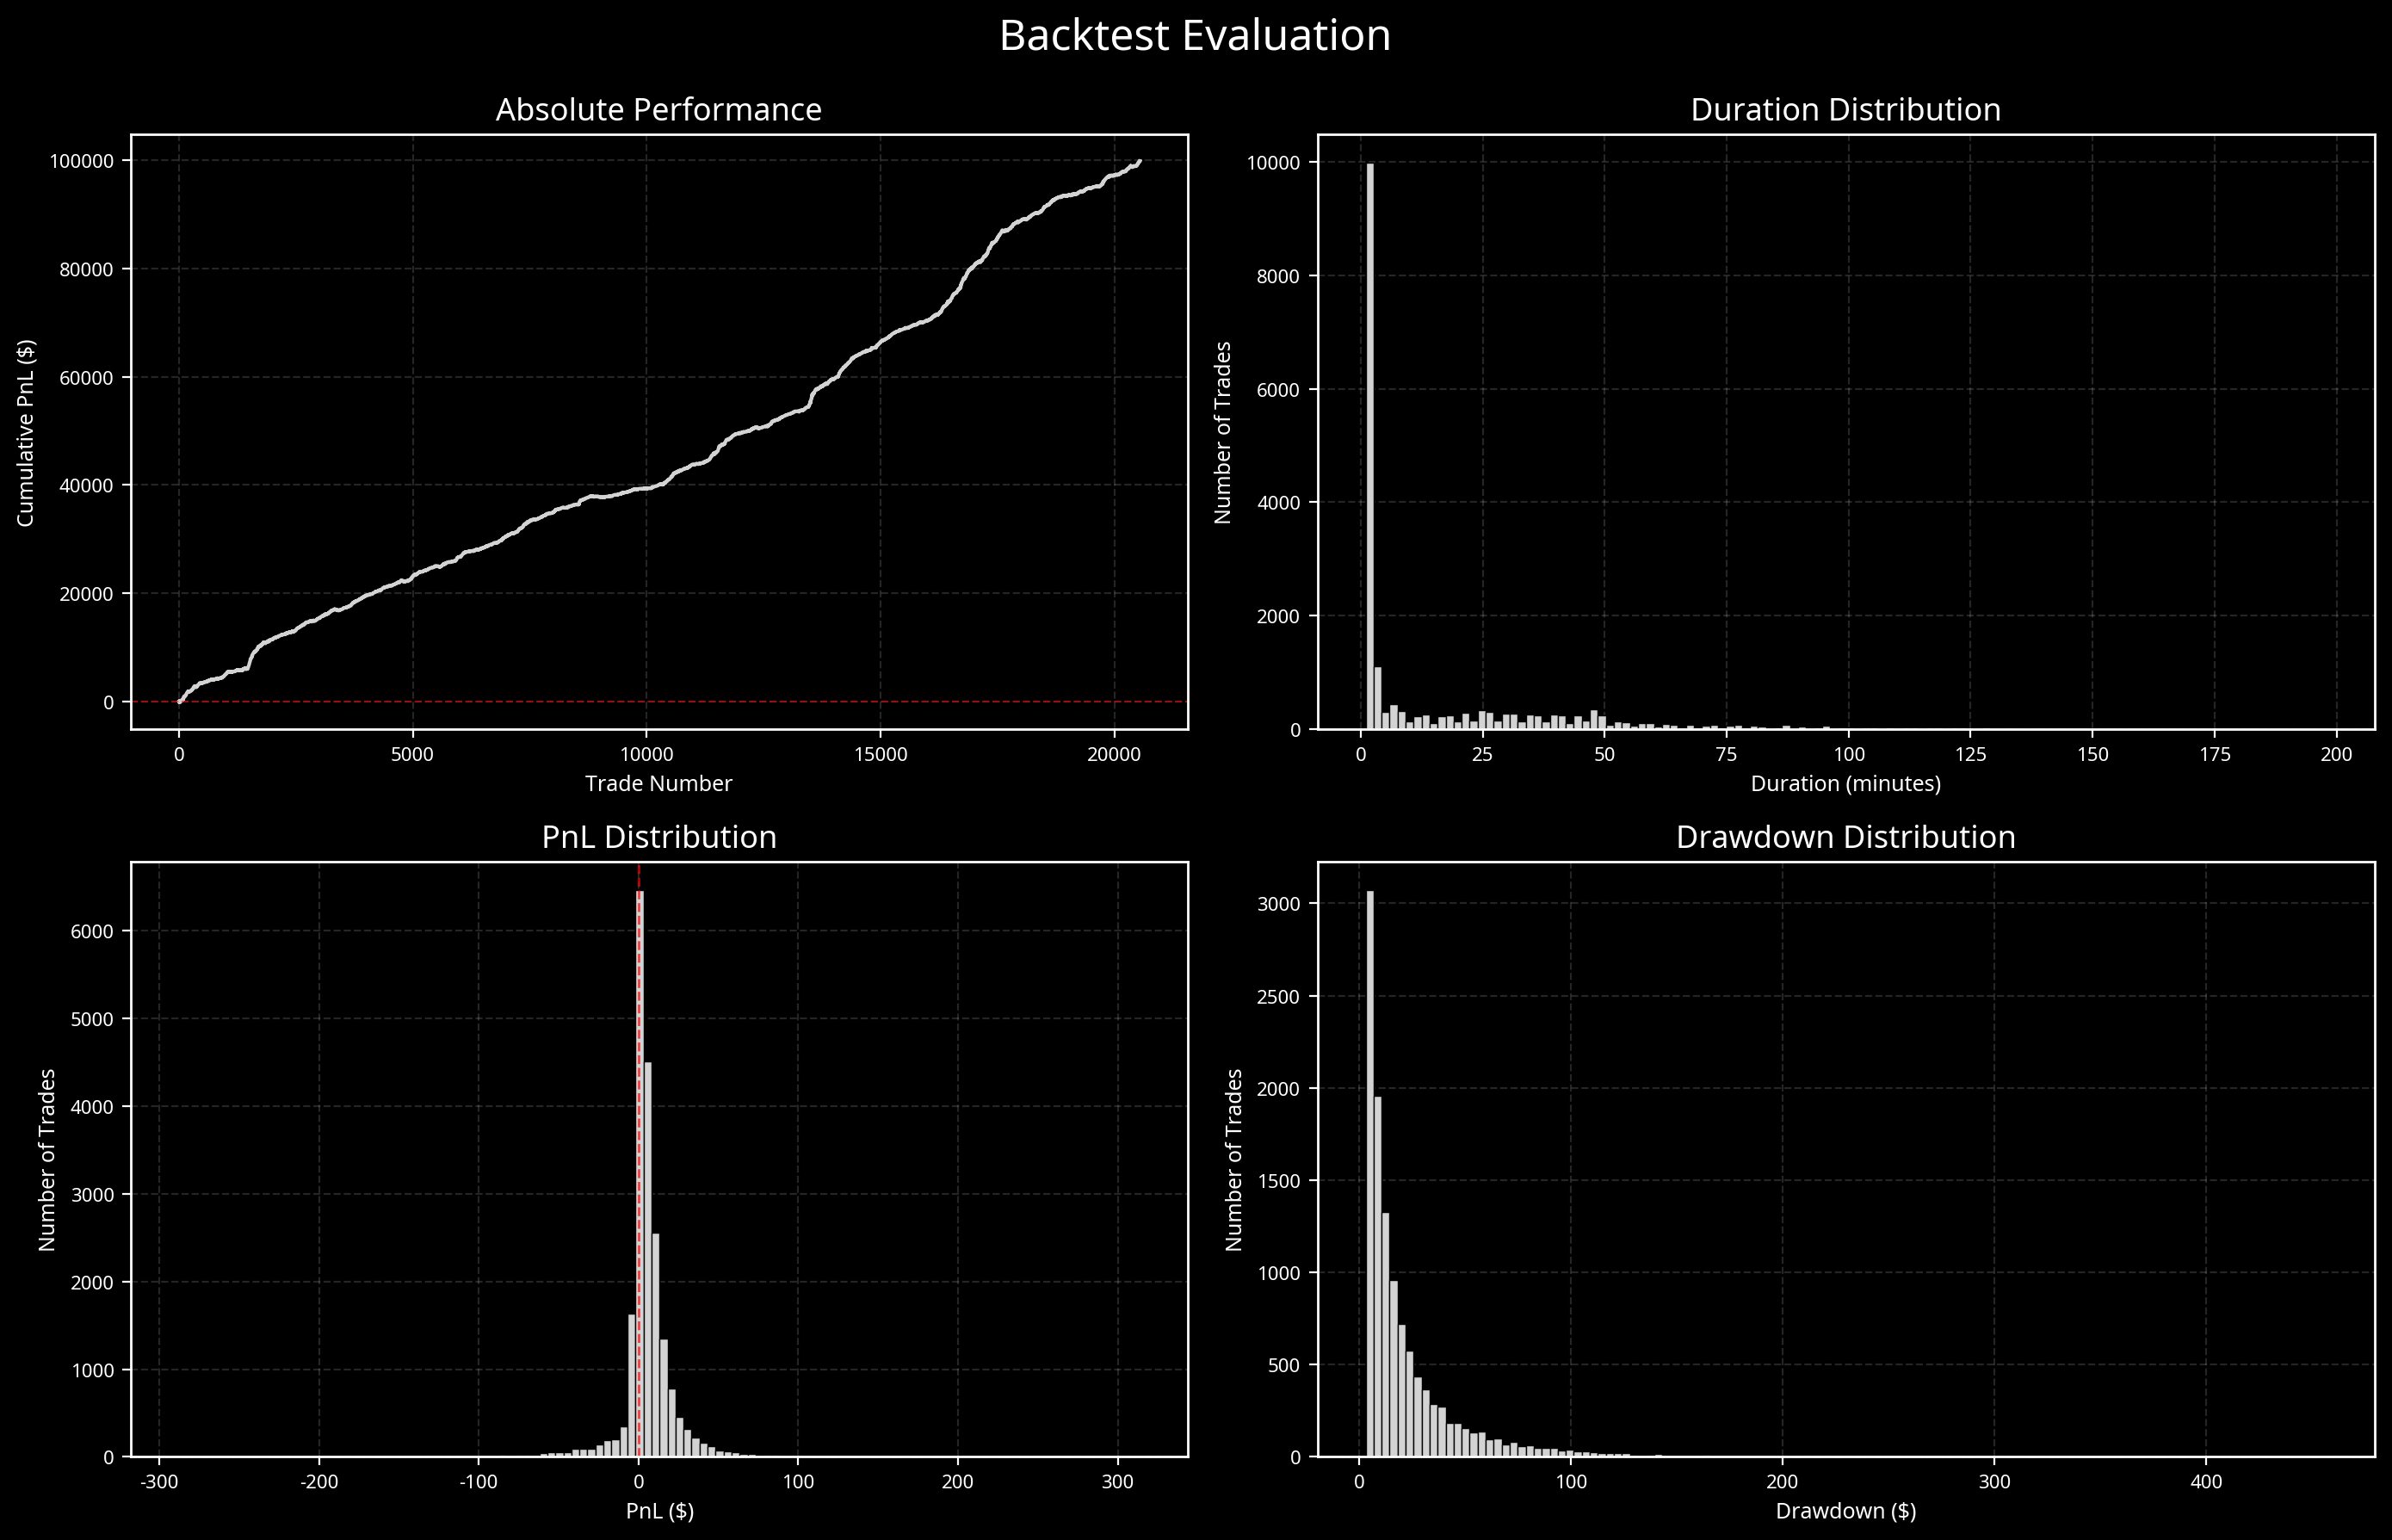

In [5]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.style.use('dark_background')


class BollingerBandsBacktest:
    """
    Bollinger Bands Arbitrage Strategy Backtest
    
    This strategy trades mean-reversion based on Bollinger Bands.
    Entry occurs at the middle band, exit at the outer bands.
    
    Warning: High drawdowns and strong dependency on fees/spreads!
    """
    
    def __init__(self, file, risk_per_trade=10000):
        """
        Args:
            file: Path to CSV file with OHLC data
            risk_per_trade: Capital per trade in USD
        """
        self.risk_per_trade = risk_per_trade
        self.df = None
        self.trades = pd.DataFrame(columns=[
            'entrytime', 'exittime', 'duration', 'type', 
            'entry', 'exit', 'pnl', 'dd'
        ])
        self.data_loaded = self._load_data(file)
        
        # Backtest parameters (set later)
        self.bb_length = None
        self.bb_std = None

    def _load_data(self, file):
        """Loads and filters market data"""
        try:
            self.df = pd.read_csv(
                file, 
                index_col=0, 
                parse_dates=True
            )
        except FileNotFoundError:
            print(f"Error: File '{file}' not found!")
            return False
        
        # Filter: Only main trading hours (NY premarket to NY lunch)
        self.df = self.df.between_time('08:00', '12:00')
        print(f"Data loaded: {len(self.df)} bars")
        return True
    
    def _record_trade(self, entrytime, exittime, trade_type, entry_price, 
                     exit_price, max_dd, fees=0.0003):
        """
        Records a trade with all relevant metrics
        
        Args:
            fees: Fees/slippage as decimal (0.0003 = 0.03%)
        """
        idx = len(self.trades)
        duration_minutes = (
            (exittime.hour * 60 + exittime.minute) - 
            (entrytime.hour * 60 + entrytime.minute)
        )
        
        # PnL calculation
        if trade_type == 'long':
            pnl = (exit_price - entry_price) * (self.risk_per_trade / entry_price)
        else:  # short
            pnl = (entry_price - exit_price) * (self.risk_per_trade / entry_price)
        
        pnl -= self.risk_per_trade * fees  # Deduct fees
        dd_in_dollars = max_dd * self.risk_per_trade + self.risk_per_trade * fees
        
        # Save trade
        self.trades.loc[idx] = {
            'entrytime': entrytime.time(),
            'exittime': exittime.time(),
            'duration': duration_minutes,
            'type': trade_type,
            'entry': entry_price,
            'exit': exit_price,
            'pnl': pnl,
            'dd': dd_in_dollars
        }
    
    def backtest(self, bb_length=20, bb_std=2, adx_length=14):
        """
        Executes the backtest
        
        Strategy Logic:
        - Entry: Price crosses middle band with sufficient ADX
        - Exit: Price reaches opposite outer band
        - Thesis: Price moves like a sine wave around the mean (Brownian Motion)
        
        Args:
            bb_length: Lookback period for Bollinger Bands
            bb_std: Standard deviations for BB
            adx_length: Lookback period for ADX
        """
        self.bb_length = int(bb_length)
        self.bb_std = float(bb_std)
        
        print(f"\nBacktest running with BB({bb_length}, {bb_std}), ADX({adx_length})...")
        
        for day, daily_df in self.df.groupby(self.df.index.date):
            if len(daily_df.dropna()) < 240:  # At least 4 hours of data required
                continue
            
            # Calculate indicators
            bband = ta.bbands(
                close=daily_df['Close'], 
                length=bb_length, 
                std=bb_std
            )
            adx = ta.adx(
                close=daily_df['Close'],
                high=daily_df['High'],
                low=daily_df['Low'],
                length=adx_length
            )
            
            # Merge data
            data = pd.concat([
                daily_df,
                bband[f'BBU_{self.bb_length}_{self.bb_std}'].rename('bb_high'),
                bband[f'BBL_{self.bb_length}_{self.bb_std}'].rename('bb_low'),
                bband[f'BBM_{self.bb_length}_{self.bb_std}'].rename('bb_mid'),
                adx[f'ADX_{adx_length}'].rename('adx')
            ], join='inner', axis=1).dropna()
            
            # ATR filter (only trade with sufficient volatility)
            adx_threshold = data['adx'].rolling(14).mean()
            
            # Trade tracking variables
            in_trade = False
            direction = None
            entry_price = None
            entry_time = None
            drawdown = {'price': np.nan, 'pct': np.nan}
            
            # Iterate through each bar
            for timestamp, bar in data.iterrows():
                
                if not in_trade:  # ENTRY LOGIC
                    # Only enter with sufficient volatility
                    if (bar['adx'] > adx_threshold.loc[timestamp] and 
                        not np.isnan(adx_threshold.loc[timestamp])):
                        
                        # Long: Price above middle band
                        if bar['Close'] > bar['bb_mid']:
                            entry_price = bar['Close']
                            entry_time = timestamp
                            direction = 'long'
                            in_trade = True
                        
                        # Short: Price below middle band
                        elif bar['Close'] < bar['bb_mid']:
                            entry_price = bar['Close']
                            entry_time = timestamp
                            direction = 'short'
                            in_trade = True
                
                else:  # EXIT LOGIC
                    
                    if direction == 'long':
                        # Exit: Price reaches upper band
                        if bar['High'] >= bar['bb_high']:
                            self._record_trade(
                                entry_time, timestamp, direction,
                                entry_price, bar['High'], drawdown['pct']
                            )
                            # Reset to defaults
                            in_trade = False
                            direction = None
                            drawdown = {'price': np.nan, 'pct': np.nan}
                        
                        else:  # Track drawdown
                            if np.isnan(drawdown['price']) or bar['Low'] < drawdown['price']:
                                drawdown['price'] = bar['Low']
                                drawdown['pct'] = abs(entry_price / bar['Low'] - 1)
                    
                    elif direction == 'short':
                        # Exit: Price reaches lower band
                        if bar['Low'] <= bar['bb_low']:
                            self._record_trade(
                                entry_time, timestamp, direction,
                                entry_price, bar['Low'], drawdown['pct']
                            )
                            # Reset to defaults
                            in_trade = False
                            direction = None
                            drawdown = {'price': np.nan, 'pct': np.nan}
                        
                        else:  # Track drawdown
                            if np.isnan(drawdown['price']) or bar['High'] > drawdown['price']:
                                drawdown['price'] = bar['High']
                                drawdown['pct'] = abs(bar['High'] / entry_price - 1)
        
        print(f"Backtest completed: {len(self.trades)} trades generated")
    
    def evaluate(self):
        """Calculates performance metrics and creates plots"""
        if self.trades.empty:
            print("No trades available!")
            return
        
        # Calculate metrics
        total_pnl = self.trades['pnl'].sum()
        n_trades = len(self.trades)
        avg_pnl = self.trades['pnl'].mean()
        avg_dd = self.trades['dd'].dropna().mean()
        avg_duration = self.trades['duration'].mean()
        win_rate = (self.trades['pnl'] > 0).sum() / n_trades * 100
        
        # Output
        print('\n' + '='*50)
        print('BACKTEST EVALUATION')
        print('='*50)
        print(f'Total PnL:         {total_pnl:>10,.0f} USD  ({n_trades} trades)')
        print(f'Risk per Trade:    {self.risk_per_trade:>10,.0f} USD')
        print(f'Avg PnL:           {avg_pnl:>10,.2f} USD')
        print(f'Avg Drawdown:      {avg_dd:>10,.2f} USD')
        print(f'Avg Duration:      {avg_duration:>10.0f} minutes')
        print(f'Win Rate:          {win_rate:>10.1f} %')
        print('='*50 + '\n')
        
        self._create_plots()
    
    def _create_plots(self):
        """Creates visualizations of backtest results"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 9))
        fig.suptitle(
            'Backtest Evaluation', 
            fontsize=18, 
            fontweight='bold', 
            y=0.99
        )
        axes = axes.ravel()
        
        # 1. Cumulative Performance
        axes[0].plot(
            self.trades.index, 
            self.trades['pnl'].cumsum(), 
            color='lightgrey', 
            linewidth=1.5
        )
        axes[0].axhline(0, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        axes[0].set_ylabel('Cumulative PnL ($)')
        axes[0].set_xlabel('Trade Number')
        axes[0].set_title('Absolute Performance')
        
        # 2. Duration Distribution
        axes[1].hist(
            self.trades['duration'], 
            bins=120, 
            color='lightgrey', 
            edgecolor='black'
        )
        axes[1].set_xlabel('Duration (minutes)')
        axes[1].set_ylabel('Number of Trades')
        axes[1].set_title('Duration Distribution')
        
        # 3. PnL Distribution
        axes[2].hist(
            self.trades['pnl'], 
            bins=120, 
            color='lightgrey', 
            edgecolor='black'
        )
        axes[2].axvline(0, color='red', linestyle='--', alpha=0.7, linewidth=1)
        axes[2].set_xlabel('PnL ($)')
        axes[2].set_ylabel('Number of Trades')
        axes[2].set_title('PnL Distribution')
        
        # 4. Drawdown Distribution
        axes[3].hist(
            self.trades['dd'], 
            bins=120, 
            color='lightgrey', 
            edgecolor='black'
        )
        axes[3].set_xlabel('Drawdown ($)')
        axes[3].set_ylabel('Number of Trades')
        axes[3].set_title('Drawdown Distribution')
        
        # Styling for all subplots
        for ax in axes:
            ax.tick_params(axis='both', labelsize=8)
            ax.set_ylabel(ax.get_ylabel(), fontsize=9)
            ax.set_xlabel(ax.get_xlabel(), fontsize=9)
            ax.set_title(ax.get_title(), fontstyle='oblique', fontsize=13)
            ax.grid(True, linestyle='--', alpha=0.15)
        
        plt.tight_layout()
        plt.savefig(
            f'eval_BB{self.bb_length}_{self.bb_std}.png', 
            dpi=300, 
            bbox_inches='tight'
        )
        plt.show()
    
    def run(self):
        """Executes the complete backtest process"""
        if not self.data_loaded:
            print("Error: No data loaded!")
            return
        
        self.backtest(30,2.6,14)
        self.evaluate()


if __name__ == '__main__':
    backtest = BollingerBandsBacktest('NQ_OHLC_1m.csv', risk_per_trade=10000)
    backtest.run()